### Imports and Data Loading

In [64]:
import datetime
import pathlib

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL, AutoETS
from utils import check_autocorr_ts
from utilsforecast.preprocessing import fill_gaps
from weather_parse import weather_parse


#### Explode Data into Separate Columns

#### Read Saved Data  
[Data Source](https://www.ncei.noaa.gov/access/search/data-search/global-hourly?dataTypes=TMP&dataTypes=DEW&dataTypes=AA1&dataTypes=VIS&dataTypes=WND&bbox=41.000,-74.261,40.558,-73.499&pageNum=1&startDate=2010-01-01T00:00:00&endDate=2023-02-01T23:59:59)  
[Type Documentation](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)

In [67]:

root_dir = pathlib.Path("../data")
weather_dir = root_dir/"weather"
save_dir = weather_dir/'unprocessed'
try:
    weather_df = pd.read_parquet(save_dir)
    if len(weather_df) == 0:
        raise FileNotFoundError
except FileNotFoundError:
    weather_df = weather_parse()
    weather_df.to_parquet(save_dir, partition_cols=['year'])


In [68]:
weather_df.describe().T.convert_dtypes()


,count,mean,min,25%,50%,75%,max,std
DATE,176196,2016-07-23 04:06:27.184498944,2010-01-01 00:00:00,2013-04-20 04:45:45,2016-08-03 23:21:00,2019-10-23 13:06:00,2023-02-01 23:51:00,<NA>
temperature_c,176147,13.623259,-17.2,5.6,13.9,22.0,39.4,9.738035
precip_period_hrs,135453,1.354964,1.0,1.0,1.0,1.0,24.0,1.91344
precip_accumulation_mm,135453,0.453463,0.0,0.0,0.0,0.0,999.9,6.446545
direction_deg,176196,240.585535,10.0,80.0,210.0,310.0,999.0,217.290135
speed_mps,176196,5.804343,0.0,3.1,4.6,6.2,999.9,32.586874
dew_temperature_c,176134,5.929446,-27.2,-2.2,6.7,14.4,25.6,10.319583
year,176196,2016.064127,2010.0,2013.0,2016.0,2019.0,2023.0,3.76192


In [70]:
# weather_df.describe(include='string').T.convert_dtypes()


In [71]:
weather_df


,DATE,temperature_c,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,year
0,2010-01-01 00:00:00,1.1,<NA>,<NA>,60,2.1,-1.1,2010
1,2010-01-01 00:51:00,1.1,1,0.0,30,2.1,-1.1,2010
2,2010-01-01 01:36:00,1.0,1,0.0,40,1.5,-1.0,2010
3,2010-01-01 01:51:00,1.1,1,0.3,999,0.0,-0.6,2010
4,2010-01-01 02:01:00,1.0,1,0.3,60,1.5,-1.0,2010
...,...,...,...,...,...,...,...,...
176191,2023-02-01 20:51:00,3.3,1,0.0,260,5.7,-13.3,2023
176192,2023-02-01 21:00:00,3.3,<NA>,<NA>,260,5.7,-13.3,2023
176193,2023-02-01 21:51:00,3.3,1,0.0,270,4.1,-13.3,2023
176194,2023-02-01 22:51:00,2.8,1,0.0,290,5.1,-12.8,2023


In [72]:
for c in weather_df.select_dtypes('string').columns:
    print(c)
    display(weather_df[c].unique())
    print()


### Data Visualization

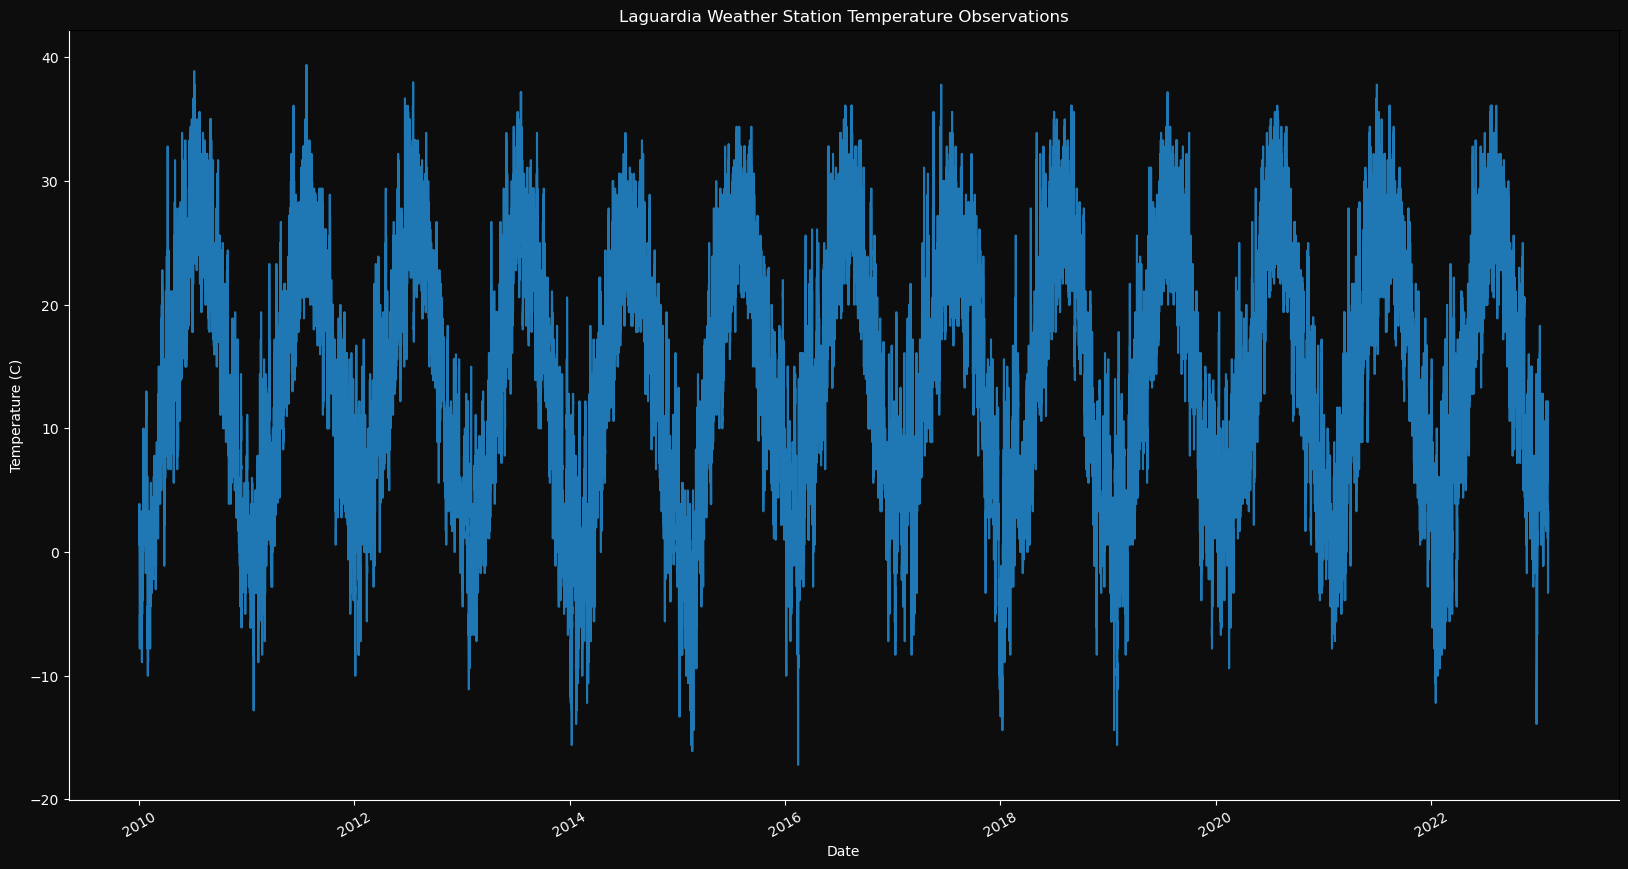

In [73]:
ax = weather_df[['DATE', 'temperature_c']].plot(
    x='DATE', y='temperature_c',
    xlabel='Date', ylabel="Temperature (C)",
    title="Laguardia Weather Station Temperature Observations",
    legend=False)

ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
fig.set_size_inches((20,10))
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
fig.savefig("../plots/laguardia_temperature.svg")

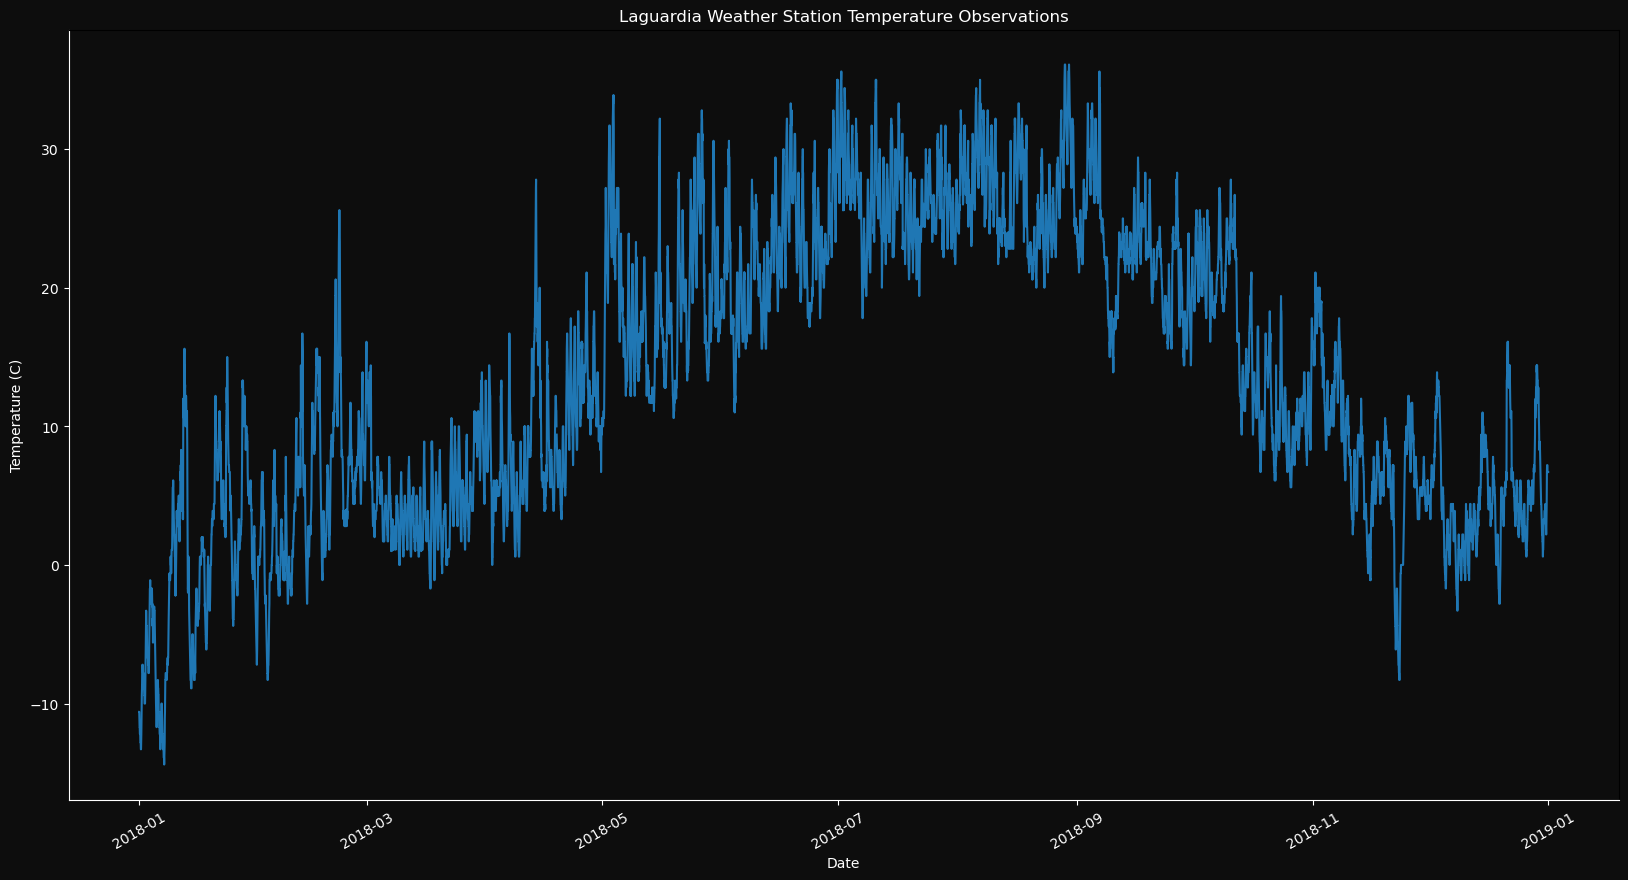

In [74]:


ax = weather_df[['DATE', 'temperature_c']]\
    [(weather_df['DATE']>=datetime.datetime(2018,1,1))
     &
     (weather_df['DATE']<datetime.datetime(2019,1,1))
     ].plot(
    x='DATE', y='temperature_c',
    xlabel='Date', ylabel="Temperature (C)",
    title="Laguardia Weather Station Temperature Observations",
    legend=False)

ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
fig.set_size_inches((20,10))
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
fig.savefig("../plots/laguardia_temp_2018.svg")


In [63]:


df_2018 = weather_df[['DATE', 'temperature_c']]\
    [(weather_df['DATE']>=datetime.datetime(2018,1,1))
     &
     (weather_df['DATE']<datetime.datetime(2019,1,1))
     ].reset_index()
df_2018.rename({'DATE':'ds', 'temperature_c':'y', 'index':'unique_id'}, axis=1, inplace=True)

df_2018.dropna(subset=['y'], inplace=True)

df_2018['ds'] = df_2018['ds'].dt.round('5min').astype('datetime64[s]')

In [64]:
df_2018.drop_duplicates(subset=['ds'], inplace=True)
df_2018.set_index('unique_id', inplace=True)
df_2018.describe()

,ds,y
count,13482,13482.000000
mean,2018-07-02 06:18:44,13.690447
min,2018-01-01 00:00:00,-14.400000
25%,2018-03-31 17:52:30,5.000000
50%,2018-07-01 18:25:00,12.800000
75%,2018-10-01 12:37:30,22.800000
max,2018-12-31 23:50:00,36.100000
std,NaN,10.101014


In [65]:
# check_autocorr_ts(df_2018.set_index('ds'), lags=(12*24))

In [66]:
# df_2018 = df_2018.reset_index().set_index('ds').asfreq('5min').reset_index()

df_2018 = df_2018.reset_index()

In [67]:
df_2018 = df_2018.convert_dtypes(dtype_backend='numpy_nullable')

df_2018.drop('unique_id', inplace=True, axis=1)
df_2018.reset_index(inplace=True)
df_2018.rename({'DATE':'ds', 'temperature_c':'y', 'index':'unique_id'}, axis=1, inplace=True)

In [68]:
df_2018

,unique_id,ds,y
0,0,2018-01-01 00:00:00,-10.6
1,1,2018-01-01 00:50:00,-10.6
2,2,2018-01-01 01:50:00,-11.1
3,3,2018-01-01 02:50:00,-11.7
4,4,2018-01-01 03:00:00,-11.7
...,...,...,...
13477,13477,2018-12-31 21:50:00,6.7
13478,13478,2018-12-31 22:50:00,6.7
13479,13479,2018-12-31 23:25:00,6.7
13480,13480,2018-12-31 23:40:00,6.7


In [97]:

sf = StatsForecast(
    models = [AutoARIMA(season_length = 12*24)],
    freq = '5min',
    verbose=True
)
sf.fit(df_2018)
pred = sf.predict(h=12, level=[99])

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [102]:
((pred['AutoARIMA-hi-99']-pred['AutoARIMA-lo-99'])**2).mean()


0.0

In [108]:
print(sf.models[0].D)

None


In [106]:
dir(sf)
dir(sf.models[0])

['D',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_conformal_intervals',
 '_add_predict_conformal_intervals',
 '_conformal_method',
 '_conformity_scores',
 '_store_cs',
 'alias',
 'allowdrift',
 'allowmean',
 'approximation',
 'biasadj',
 'blambda',
 'd',
 'fit',
 'forecast',
 'forward',
 'ic',
 'max_D',
 'max_P',
 'max_Q',
 'max_d',
 'max_order',
 'max_p',
 'max_q',
 'method',
 'new',
 'nmodels',
 'predict',
 'predict_in_sample',
 'prediction_intervals',
 'season_length',
 'seasonal',
 'seasonal_test',
 'seasonal_test_kwargs',
 'start_P',
 'start_Q',
 'start_p',
 'start_q',
 'stationary',
 'stepwise',
 'test',
 'test_kwargs',
 'trace',
 'truncate',
 'uses_exo

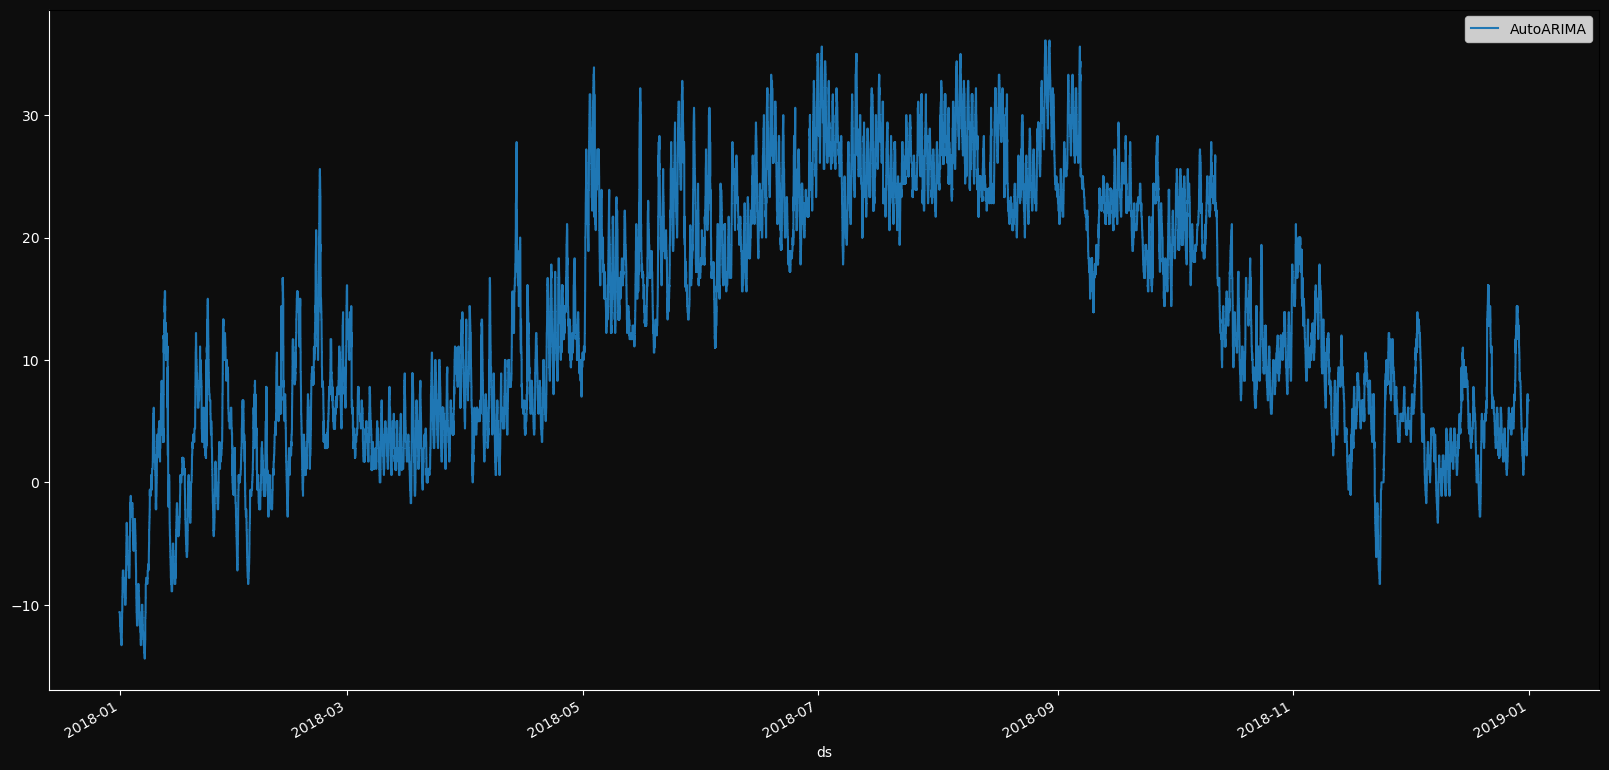

In [111]:

ax = pred.plot(x='ds', y='AutoARIMA')
ax.fill_between(pred['ds'], y2=pred['AutoARIMA-lo-99'],y1=pred['AutoARIMA-hi-99'])
fig =  ax.get_figure()
ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
fig.set_size_inches((20,10))
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
# fig.savefig("../plots/laguardia_temp_2018.svg")

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:1316: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


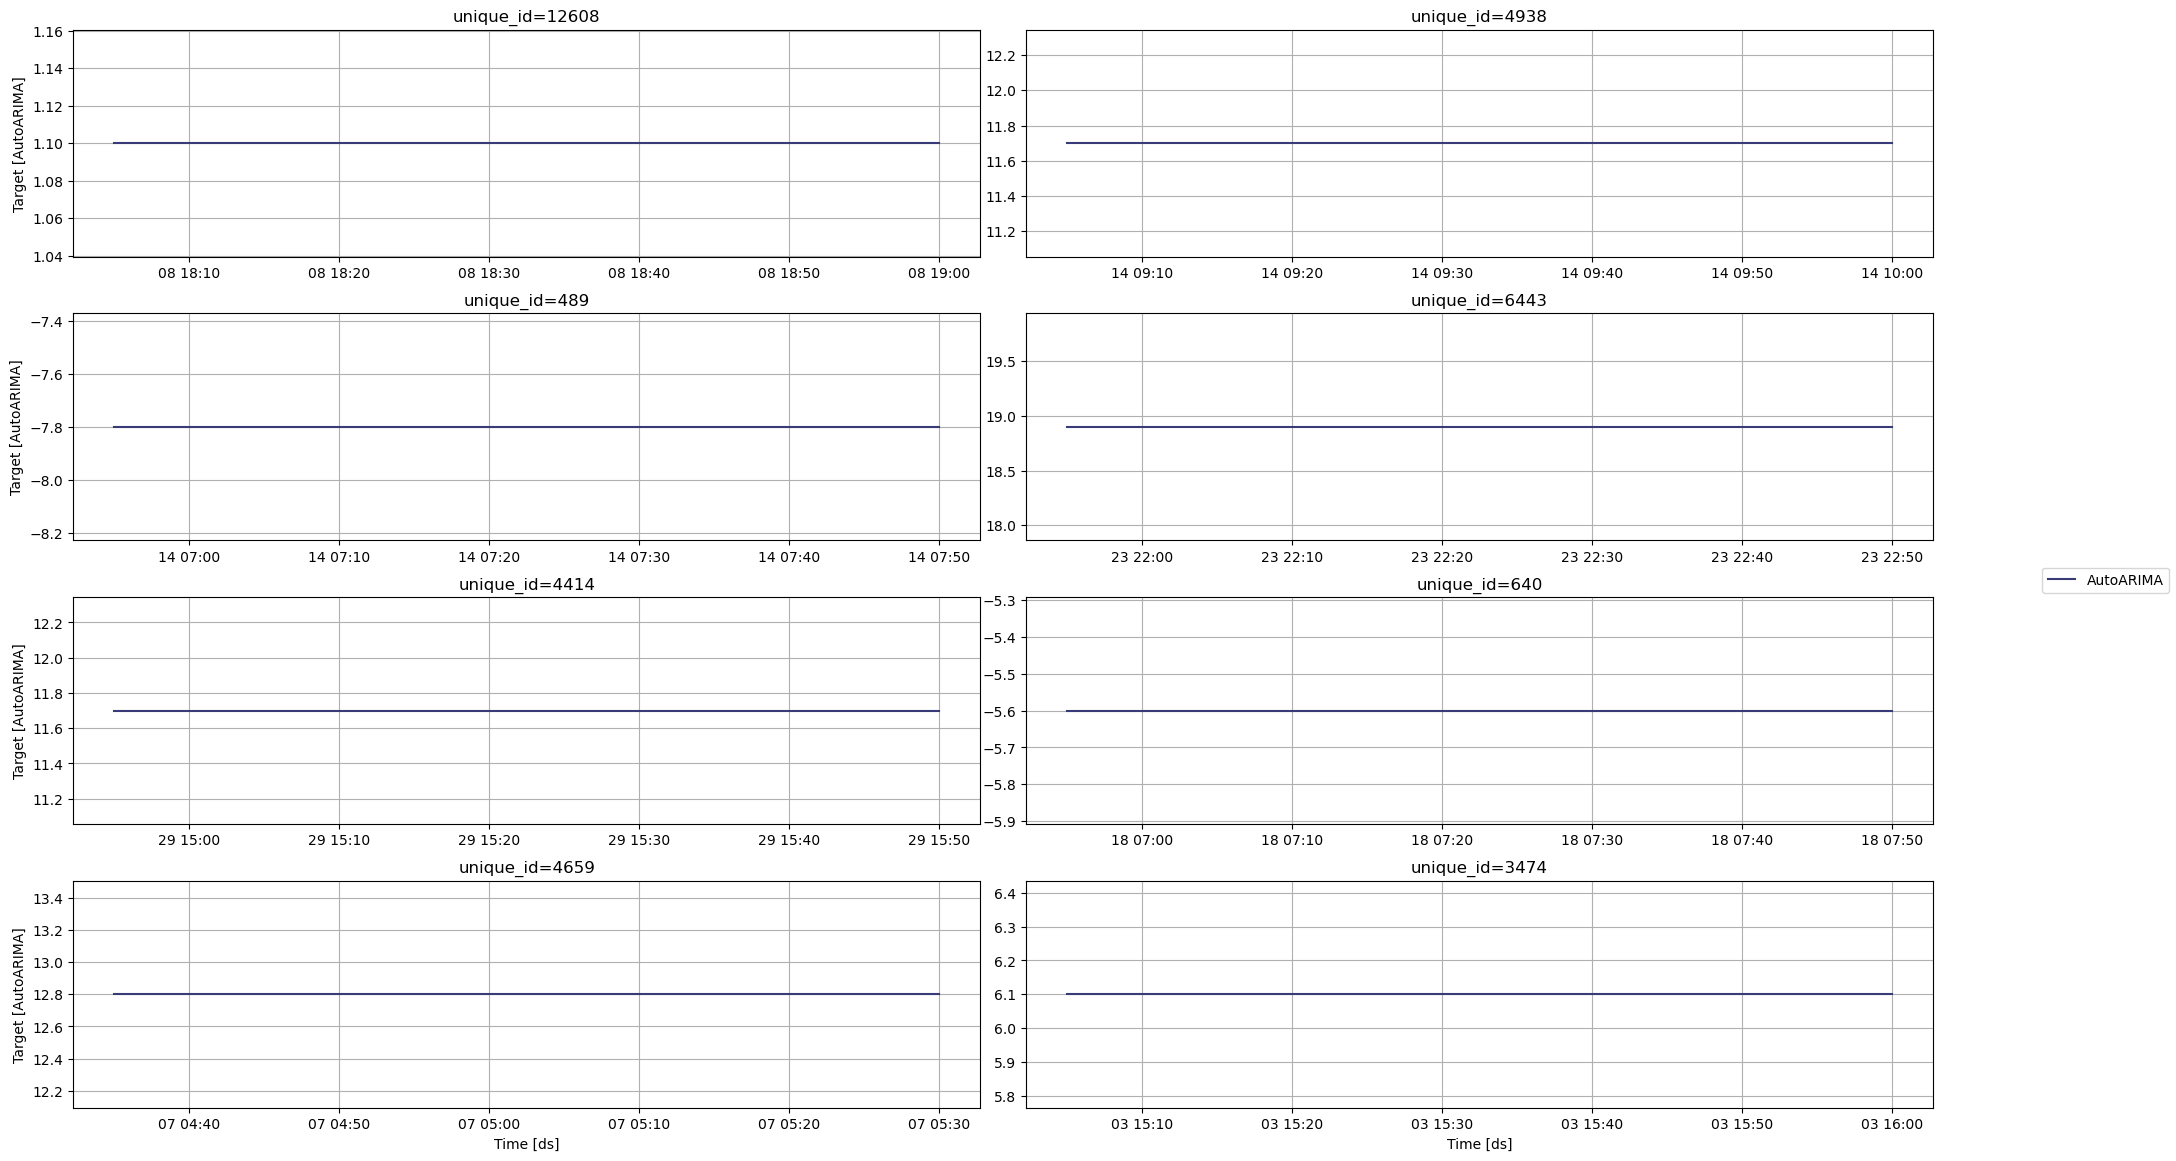

In [80]:
StatsForecast.plot(df=pred, target_col='AutoARIMA')
